In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold

warnings.filterwarnings("ignore")

In [2]:
def ml_cv_results(model_name, model, x, y, verbose=1):
    
    '''initial'''
    accuracies = []
    precisions = []
    recalls = []
    f1s = []
    
    mm = MinMaxScaler()
    
    x_ = x.to_numpy()
    y_ = y.to_numpy()
    
    count = 0
    
    '''cross-validation'''
    skf = StratifiedKFold(n_splits=5, shuffle=True)
    
    for index_train, index_test in skf.split(x_, y_):
        ## Showing the Fold
        if verbose > 0:
            count += 1
            print('Fold K=%i' % (count))
    
        ## selecting train and test
        x_train, x_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]
        
        ## applying the scale
        x_train = mm.fit_transform(x_train)
        x_test = mm.transform(x_test)
    
        ## training the model
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)

        ## saving the metrics
        accuracies.append(accuracy_score(y_test, y_pred))
        precisions.append(precision_score(y_test, y_pred))
        recalls.append(recall_score(y_test, y_pred))
        f1s.append(f1_score(y_test, y_pred))
        
        
        
    '''results'''    
    accuracy_mean, accuracy_std = np.round(np.mean(accuracies), 3), np.round(np.std(accuracies), 3)
    precision_mean, precision_std = np.round(np.mean(precisions), 3), np.round(np.std(precisions), 3)
    recall_mean, recall_std = np.round(np.mean(recalls), 3), np.round(np.std(recalls), 3)
    f1_mean, f1_std = np.round(np.mean(f1s), 3), np.round(np.std(f1s), 3)
    
    ## saving the results in a dataframe
    return pd.DataFrame({"Accuracy": "{} +/- {}".format(accuracy_mean, accuracy_std),
                        "Precision": "{} +/- {}".format(precision_mean, precision_std),
                        "Recall": "{} +/- {}".format(recall_mean, recall_std),
                        "F1": "{} +/- {}".format(f1_mean, f1_std)},
                       index=[model_name])

In [3]:
def ml_scores(model_name, y_true, y_pred):
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    
    return pd.DataFrame({'Accuracy': np.round(accuracy, 3), 
                         'Precision': np.round(precision, 3), 
                         'Recall': np.round(recall, 3),
                         'F1': np.round(f1, 3)}, 
                        index=[model_name])

In [4]:
data = pd.read_excel("./customer_churn_large_dataset.xlsx")

print(data.shape)
data.head(3)

(100000, 9)


,CustomerID,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,1.0,Customer_1,63.0,Male,Los Angeles,17.0,73.36,236.0,0.0
1,2.0,Customer_2,62.0,Female,New York,1.0,48.76,172.0,0.0
2,3.0,Customer_3,24.0,Female,Los Angeles,5.0,85.47,460.0,0.0


In [5]:
new_data = data.drop(columns=['CustomerID', 'Name'])

print(new_data.shape)
new_data.head(3)

(100000, 7)


,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
0,63.0,Male,Los Angeles,17.0,73.36,236.0,0.0
1,62.0,Female,New York,1.0,48.76,172.0,0.0
2,24.0,Female,Los Angeles,5.0,85.47,460.0,0.0


### **Perform some EDA to get to know your data better**
* *Step 1*: check for null values and duplicated columns
* *Step 2*: Perform Univariate Analysis (Check for distribution of data)
* *Step 3*: Perform Bivariate Analysis (Check for correlation b/w colns)

In [6]:
# check for null values
new_data.isna().sum()

Age                           0
Gender                        0
Location                      0
Subscription_Length_Months    0
Monthly_Bill                  0
Total_Usage_GB                0
Churn                         0
dtype: int64

In [7]:
# check for duplicated values
new_data.duplicated().sum()

0

In [8]:
# check brief description of data
new_data.describe()
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 7 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   Age                         100000 non-null  float64
 1   Gender                      100000 non-null  object 
 2   Location                    100000 non-null  object 
 3   Subscription_Length_Months  100000 non-null  float64
 4   Monthly_Bill                100000 non-null  float64
 5   Total_Usage_GB              100000 non-null  float64
 6   Churn                       100000 non-null  float64
dtypes: float64(5), object(2)
memory usage: 5.3+ MB


### **Time to check for `Distribution of Data`** 

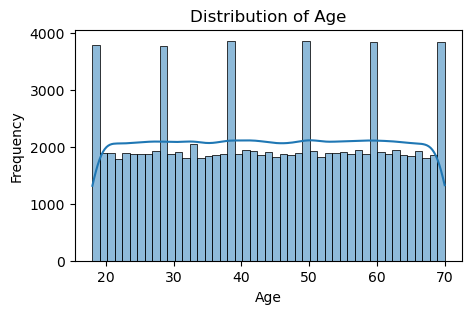

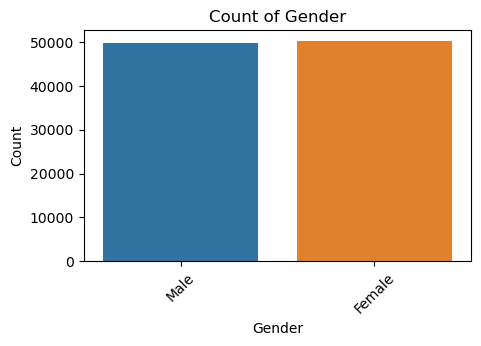

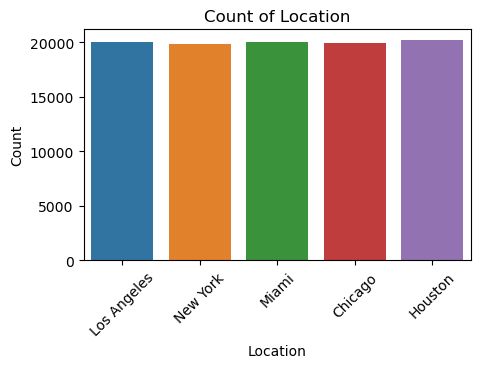

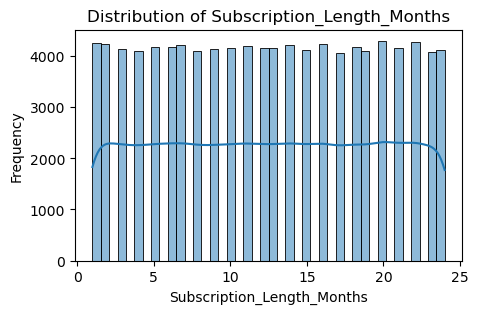

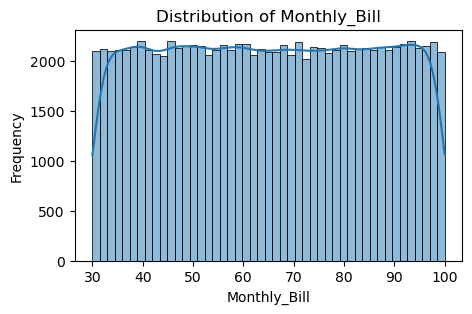

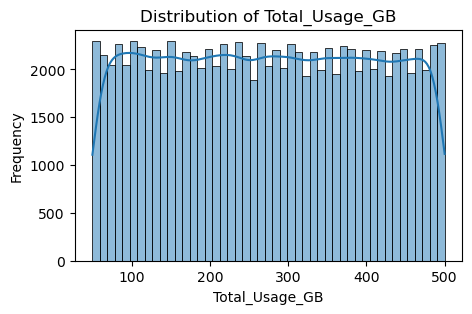

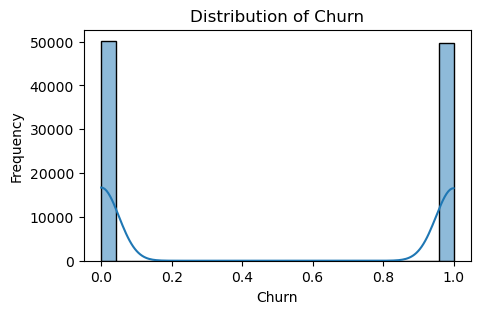

In [9]:
# Loop through each column
for column in new_data.columns:
    # Determine the data type of the column
    dtype = new_data[column].dtype
    
    # If the column is numerical, create a histogram
    if dtype in ['int64', 'float64']:
        plt.figure(figsize=(5, 3))
        sns.histplot(new_data[column], kde=True)
        plt.title(f'Distribution of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()
    
    # If the column is categorical, create a count plot
    elif dtype == 'object':
        plt.figure(figsize=(5, 3))
        sns.countplot(data=new_data, x=column)
        plt.title(f'Count of {column}')
        plt.xlabel(column)
        plt.ylabel('Count')
        plt.xticks(rotation=45)
        plt.show()


### **Timt to check for `Correlation b/w columns`**

In [10]:
new_data.sample(1)

,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
50243,58.0,Male,Chicago,18.0,96.01,423.0,0.0


<AxesSubplot:xlabel='Subscription_Length_Months', ylabel='Age'>

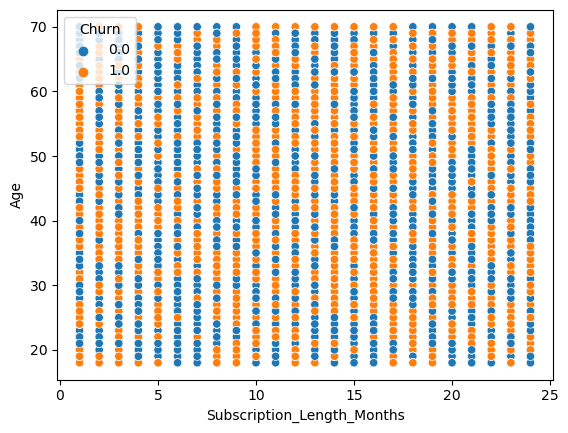

In [11]:
# checking for correlation b/w `Age ` and `Subscription_Length_Months` coln
sns.scatterplot(x=new_data['Subscription_Length_Months'], y=new_data['Age'], hue=new_data['Churn'])

<AxesSubplot:xlabel='Monthly_Bill', ylabel='Age'>

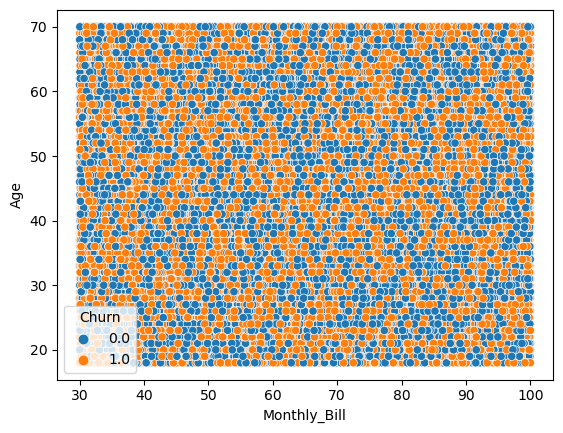

In [12]:
# checking for correlation b/w `Age ` and `Monthly_Bill` coln
sns.scatterplot(x=new_data['Monthly_Bill'], y=new_data['Age'], hue=new_data['Churn'])

<AxesSubplot:xlabel='Total_Usage_GB', ylabel='Age'>

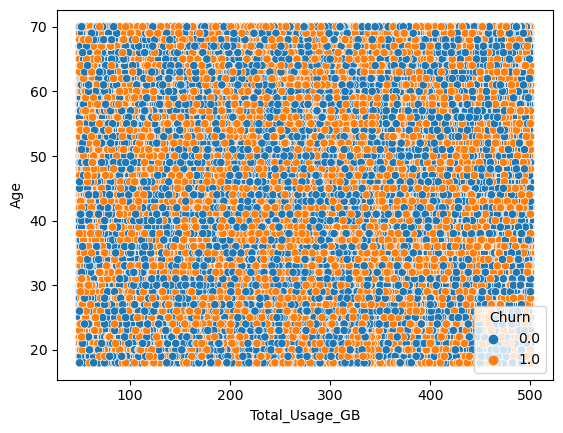

In [13]:
# checking for correlation b/w `Age ` and `Total_Usage_GB` coln
sns.scatterplot(x=new_data['Total_Usage_GB'], y=new_data['Age'], hue=new_data['Churn'])

<AxesSubplot:xlabel='Subscription_Length_Months', ylabel='Total_Usage_GB'>

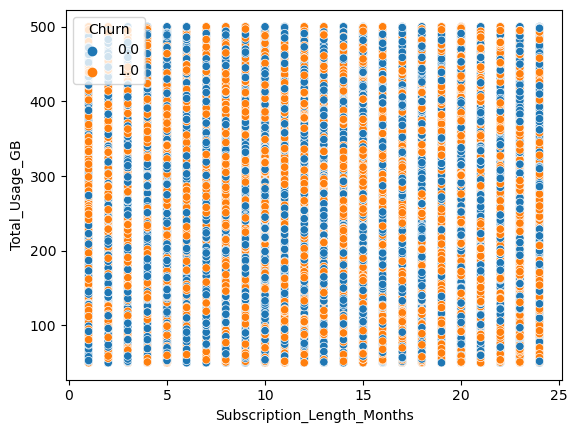

In [14]:
# checking for correlation b/w `Subscription_Length_Months` and `Total_Usage_GB` coln
sns.scatterplot(x=new_data['Subscription_Length_Months'], y=new_data['Total_Usage_GB'], hue=new_data['Churn'])

By Analyzing this data at this extent, I have got to know this dataset is arranged in the manner as there is no relation b/w any columns and even distributions are very uniformly arranged. It suggests all columns holds equal importance in **Model Building**.

In [15]:
new_data.sample(1)

,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
84785,29.0,Male,Houston,18.0,70.84,235.0,1.0


In [16]:
# Divide the data in `features` and `target`
X = new_data.iloc[:, :-1]
y = new_data.iloc[:, -1]

### **Time to Create `Model`**

In [17]:
# Divide the data in training and testing set
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42,stratify=y, shuffle=True)

X_temp.shape, X_test.shape, y_temp.shape, y_test.shape

((90000, 6), (10000, 6), (90000,), (10000,))

In [18]:
# spliting into train and valid
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=.2, stratify=y_temp,shuffle=True)

In [19]:
# one hot encoder to convert catogorical features into numerical one
from category_encoders import OneHotEncoder
categorical_features = ['Gender', 'Location']
ohe = OneHotEncoder(categorical_features, use_cat_names=True)
X_train = ohe.fit_transform(X_train)
X_valid = ohe.transform(X_valid)

X_temp = ohe.fit_transform(X_temp)
X_test = ohe.transform(X_test)

In [20]:
#rescaling
from sklearn.preprocessing   import MinMaxScaler
num_columns = ['Age', 'Subscription_Length_Months', 'Monthly_Bill', 'Total_Usage_GB']
mm = MinMaxScaler()
X_params = X_temp.copy()

X_train[num_columns] = mm.fit_transform(X_train[num_columns])
X_valid[num_columns] = mm.transform(X_valid[num_columns])

X_params[num_columns] = mm.fit_transform(X_temp[num_columns])
X_test[num_columns] = mm.transform(X_test[num_columns])

In [50]:
# Create `Model Pipeline` for Logistic Regression
LR=LogisticRegression()
clf = Pipeline(steps=[
    ('classifier', LR)
])

In [51]:
clf.fit(X_train, y_train)
print("Accuracy score of Logistic Regression is: ", clf.score(X_test, y_test))

Accuracy score of Logistic Regression is:  0.5067


In [52]:
# Check score using other metrics like `Precision Score`, `Recall Score`, `F1 Score`
y_pred = clf.predict(X_test)

lg_results = ml_scores('Logistic Regression', y_test, y_pred)
lg_results

,Accuracy,Precision,Recall,F1
Logistic Regression,0.507,0.506,0.374,0.43


In [53]:
# cross validation
lg_cv = ml_cv_results('Logistic Regression',
                      LogisticRegression(), 
                      X_temp, y_temp)
lg_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Accuracy,Precision,Recall,F1
Logistic Regression,0.5 +/- 0.001,0.498 +/- 0.001,0.394 +/- 0.027,0.439 +/- 0.017


In [25]:
# Create `Model Pipeline` for `RandomForestClassifier` 


In [26]:
rf = RandomForestClassifier(class_weight='balanced')

# Define the pipeline
clf2 = Pipeline(steps=[
    ('classifier', rf)
])

In [27]:
clf2.fit(X_train, y_train)
print("The accuracy score of Random Forest Classifier is:", clf2.score(X_test, y_test))

The accuracy score of Random Forest Classifier is: 0.4892


In [63]:
# Check score using other metrics like `Precision Score`, `Recall Score`, `F1 Score`
y_pred = clf2.predict(X_test)

rf_results = ml_scores('Random Forest', y_test, y_pred)
rf_results

,Accuracy,Precision,Recall,F1
Random Forest,0.489,0.486,0.466,0.476


In [29]:
# cross validation
lg_cv = ml_cv_results('Random Forest',
                      RandomForestClassifier(), 
                      X_temp, y_temp)
lg_cv

Fold K=1
Fold K=2
Fold K=3
Fold K=4
Fold K=5


,Accuracy,Precision,Recall,F1
Random Forest,0.497 +/- 0.004,0.494 +/- 0.005,0.476 +/- 0.007,0.485 +/- 0.006


General Machine Learning is not showing that good of a result, but actually that's very logical as there was not any relation between features and Machine Learning tries to find the best line matching the relation. So, I hadn't expected anything more.

### **Now time to head for `Deep Learning`, let's see how deep I can dig**

In [30]:
# Create `Features` & `Targets`
features = X_train
targets = y_train

In [31]:
# Create Model using `Sequential` layer
model = keras.Sequential(layers=[
    keras.layers.Dense(units=64, activation="relu", input_shape=(features.shape[1], )),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(units=128, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(units=64, activation="relu"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(units=1, activation="sigmoid")
])

In [32]:
# Add `Optimizer` and `Loss` function
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [33]:
# Check brief summary of model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                768       
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 6

In [34]:
# Finally time to train the model
model.fit(x=features, y=targets, batch_size=1000, epochs=50, validation_split=0.2)

Epoch 1/50
58/58 [==============================] - 2s 13ms/step - loss: 0.6948 - accuracy: 0.4976 - val_loss: 0.6931 - val_accuracy: 0.5006
Epoch 2/50
58/58 [==============================] - 1s 9ms/step - loss: 0.6934 - accuracy: 0.5037 - val_loss: 0.6931 - val_accuracy: 0.5085
Epoch 3/50
58/58 [==============================] - 1s 10ms/step - loss: 0.6935 - accuracy: 0.5001 - val_loss: 0.6930 - val_accuracy: 0.5051
Epoch 4/50
58/58 [==============================] - 1s 10ms/step - loss: 0.6932 - accuracy: 0.5073 - val_loss: 0.6931 - val_accuracy: 0.5050
Epoch 5/50
58/58 [==============================] - 1s 11ms/step - loss: 0.6932 - accuracy: 0.5031 - val_loss: 0.6933 - val_accuracy: 0.5008
Epoch 6/50
58/58 [==============================] - 1s 11ms/step - loss: 0.6932 - accuracy: 0.5028 - val_loss: 0.6931 - val_accuracy: 0.5058
Epoch 7/50
58/58 [==============================] - 1s 10ms/step - loss: 0.6931 - accuracy: 0.5058 - val_loss: 0.6930 - val_accuracy: 0.5040
Epoch 8/50
58/

In [35]:
# Evaluate the model on the validation data for this fold
results=[]
loss, accuracy = model.evaluate(X_valid, y_valid, verbose=0)
results.append(accuracy)
# Calculate and print the mean and standard deviation of the cross-validation results
mean_accuracy = np.mean(results)
std_accuracy = np.std(results)
print(f'Mean Accuracy: {mean_accuracy:.4f}')
print(f'Standard Deviation: {std_accuracy:.4f}')

Mean Accuracy: 0.5041
Standard Deviation: 0.0000


Even a well curated `Deep Learning` model was not able to get accuracy over 51% on validation set. At the very least this was expected with the dataset it was training on.

In [36]:
# Test the model
test_features = X_test
test_targets = y_test

model.evaluate(test_features, test_targets)

313/313 [==============================] - 1s 2ms/step - loss: 0.6933 - accuracy: 0.5018


[0.6933169960975647, 0.501800000667572]

In [64]:
# Model performance metrics
modeling_performance = pd.concat([lg_results, rf_results])
modeling_performance.sort_values(by="F1", ascending=True)

,Accuracy,Precision,Recall,F1
Logistic Regression,0.507,0.506,0.374,0.430
Random Forest,0.489,0.486,0.466,0.476


 Though I was not able to get better accuracy on this dataset, and I think dataset is also on partially fault there. But now let's move forward to next step and that is deploy this model on [`Streamlit Website`](https://customerchurnprediction.streamlit.app).

In [37]:
# Deploy the model using `pickle` module
import pickle

pickle.dump(clf, open("model.pkl", 'wb'))